# Deep Q-Learning For Cartpole 

In [2]:
# Import Packages
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
Num GPUs Available:  0


In [4]:
# create the envirnment
env = gym.make("CartPole-v1")

In [5]:
# Get the observation space and actionn space
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

print('The observation space is: ', observation_space)
print('The action space: ', action_space)

The observation space is:  4
The action space:  2


In [6]:
# Test environment
state = env.reset()
state_next, reward, terminal, info = env.step(env.action_space.sample())
print('Next_state: ', state_next)
print('Rewards:',   reward)

Next_state:  [-0.02341375  0.18302703  0.03236985 -0.29296016]
Rewards: 1.0


In [9]:
# Parameters
GAMMA = 0.95                       # discount factor
LEARNING_RATE = 0.001              # learning rate for optimiser

MEMORY_SIZE = 10000                # memeory size of the deque
BATCH_SIZE = 20                    # Batch size for training 

EXPLORATION_MAX = 1.0              
EXPLORATION_MIN = 0.1
EXPLORATION_DECAY = 0.995

exploration_rate = EXPLORATION_MAX

In [10]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(24, input_shape=(observation_space,), activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(action_space, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Append experience to memory
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

In [12]:
# Function to retuen an action based on the state
def act(state):
    
    # Return random action if epsilon 
    if np.random.rand() < exploration_rate:
        return random.randrange(action_space)
    
    # Else return the action predicted by model
    q_values = model.predict(state)
    
    return np.argmax(q_values[0])

In [14]:
# define training strategy
def train_sample(batch):
    ''' 
    function to train via each sample
    '''
        
    # for each experience in the batch, update the network with new q_update
    for state, action, reward, state_next, terminal in batch:
        
        # q_target is reward if terminal 
        q_update = reward
        
        # else q_target is the discounted reward 
        if not terminal:
            q_update = (reward + GAMMA * np.amax(model.predict(state_next)[0]))
            
        # Get the vector of Q_target = [Q_target(1), Q_target(2)], only the Q_target index of the action is updated 
        q_values = model.predict(state)
        q_values[0][action] = q_update
        
        # Fit a single sample to the model
        model.fit(state, q_values, verbose=0)

def train_batch:
    ''' 
    function to train via each sample
    '''
    # Initialise list of target Q and states
    target_Q = []
    state_train = []

    # Extract each parameter from batch
    for state, action, reward, state_next, done in batch:

        # add states to list
        state_train.append(state)

        # Add the target Q to list
        if done:
            Q_values = model.predict(state[tf.newaxis,...])
            Q_values[0][action] = reward
            target_Q.append(Q_values[0])
        else:
            Q_values = model.predict(state[tf.newaxis,...])
            Q_values[0][action] = reward + GAMMA * np.max(model.predict(state_next)[0])
            target_Q.append(Q_values[0])

    # turn states and target Q in numpy arrays
    state_train = np.array(state_train)
    target_Q = np.array(target_Q)
    
    # Fit a a batch of results
    model.fit(state, q_values, verbose=0)

In [18]:
### Learning function ###

def experience_replay():
    
    global exploration_rate
    
    # Start training only if memeory size has reached beyond batch size
    if len(memory) < BATCH_SIZE:
        return
    
    # Take a sample batch from the memory
    batch = random.sample(memory, BATCH_SIZE)
    
    # train procedure
    train_sample(batch)
        
    # Reduce the exploration 
    exploration_rate *= EXPLORATION_DECAY
    exploration_rate = max(EXPLORATION_MIN, exploration_rate)


In [19]:
def test(model, n_episodes):
    ''' 
    function to test the result of the model for n_episodes and return average
    rewards
    '''
    
    # store average rewards
    avg_rewards = 0
    
    for i in range(1, n_episodes+1):

        state = env.reset()
        done = False 
        total_rewards = 0
        
        # until done 
        while not done:
            
            # take an action in the max q_table
            action = np.argmax(model.predict(np.array([state]))[0])
            state, reward, done, info = env.step(action)
            
            # acculmulate rewards
            total_rewards += reward
        
        avg_rewards = avg_rewards + 1/(i) * (total_rewards - avg_rewards)
          
    return avg_rewards

In [20]:
### Learning in the environment ###

# Initialise the run
memory = deque(maxlen=MEMORY_SIZE)
run = 0
N = 100

# Initialise score capture
run_list = []
avg_score_list = []
step_list = []

# Run for N episodes
for i in range(0,N):
    
    # update run number
    run += 1
    
    # Initialise environment 
    state = env.reset()
    terminal = False
    state = np.reshape(state, [1, observation_space])
    step = 0
    
    # Run each episode
    while not terminal:
        
        # update the step number 
        step += 1
        
        # choose an action
        action = act(state)
        
        # Take a step
        state_next, reward, terminal, info = env.step(action)
        
        # Reward negatively if episode ended
        reward = reward if not terminal else -reward
        
        # reshape state_next to format of model.predict()
        state_next = np.reshape(state_next, [1, observation_space])
        
        # Add experience to memory
        remember(state, action, reward, state_next, terminal)
        
        # set next state
        state = state_next
        
        # End the epsiode if step > 200 
        if step > 200:
            terminal = True
        
        # Print message at the end of every episode 
        if terminal:
            avg_rewards = test(model, 5)
            
            # append history of score
            run_list.append(run)
            step_list.append(step)
            avg_score_list.append(avg_rewards)
            
            print("Run: " + str(run) + ", exploration: " + str(exploration_rate) + ", average score: " + str(avg_rewards))

        # Train for a batch of batch size 
        experience_replay()
    
print('Done Training!')        

Run: 1, exploration: 1.0, average score: 10.2
Run: 2, exploration: 0.918316468354365, average score: 9.4
Run: 3, exploration: 0.8142285204175609, average score: 10.0
Run: 4, exploration: 0.6662995813682115, average score: 9.6
Run: 5, exploration: 0.6274028820538087, average score: 9.4
Run: 6, exploration: 0.5732736268885887, average score: 8.6
Run: 7, exploration: 0.5371084840724134, average score: 9.4
Run: 8, exploration: 0.5032248303978422, average score: 9.2
Run: 9, exploration: 0.47622912292284103, average score: 9.4
Run: 10, exploration: 0.45522245551230495, average score: 9.6
Run: 11, exploration: 0.4351424010585501, average score: 10.0
Run: 12, exploration: 0.4117990041127769, average score: 9.4
Run: 13, exploration: 0.39166620452737816, average score: 9.4
Run: 14, exploration: 0.3472722151889232, average score: 9.6
Run: 15, exploration: 0.3237376186352221, average score: 9.2
Run: 16, exploration: 0.29580711868545667, average score: 8.8
Run: 17, exploration: 0.2743815040481898, 

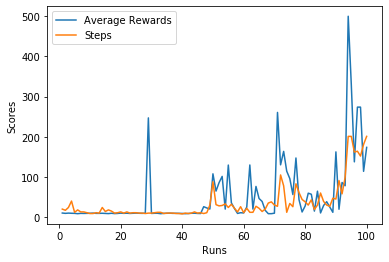

In [21]:
# plot 
plt.plot(run_list, avg_score_list, run_list, step_list)
plt.ylabel('Scores')
plt.xlabel('Runs')
plt.legend(['Average Rewards', 'Steps'])
plt.show()

In [22]:
# run test
n_episodes = 50
avg_rewards = test(model, n_episodes)
print("After " + str(n_episodes) + " episodes, the average score is " + str(avg_rewards))

After 50 episodes, the average score is 159.22


In [23]:
len(memory)

3586